# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [1]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split



plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [2]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [3]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [4]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32)


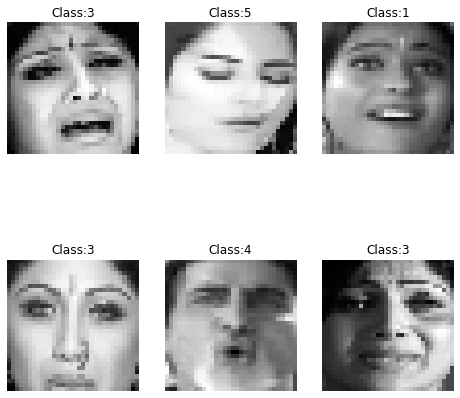

In [5]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [6]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

#  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [7]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [8]:
def get_kernel_pca(X, k,kernel='sigmoid', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [9]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [10]:
def get_kernel_lda(X,y,k,kernel='sigmoid',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [11]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [12]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________
## Ans: 
Eigen face corresponds to the eigen vectors used for recognising the human faces. It forms a set of basic facial features features which can be usd to describe a human face.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

## Ans:
It can be observed that the cartoon Dataset requires more eigen vectors for representation. the Yale dataset can be represented by few, asa few as 75 eigen vectors and IMFD dataset can be represented very well with 200 eigen vectors. The cartoon dataset need more eigen vectors for representation ie around 300. This could due to the fact that in the cartoon dataset each person has different cartoon representations leading to large range for different features. this makes it difficult for its representation with fewer eigen vectors.

This can also be validated from the eigen spectrum of each of the dataset. The spectrum for the cartoon dataset saturates after 300, for Yale it can be observed at 75 and for IMFD the saturation can be observed post 200.

Dataset shape: (400, 32, 32)
Dataset shape: (165, 32, 32)
Dataset shape: (672, 32, 32)


Text(0.5, 0.98, 'Cartoon Dataset (showing only first 30 of 300)')

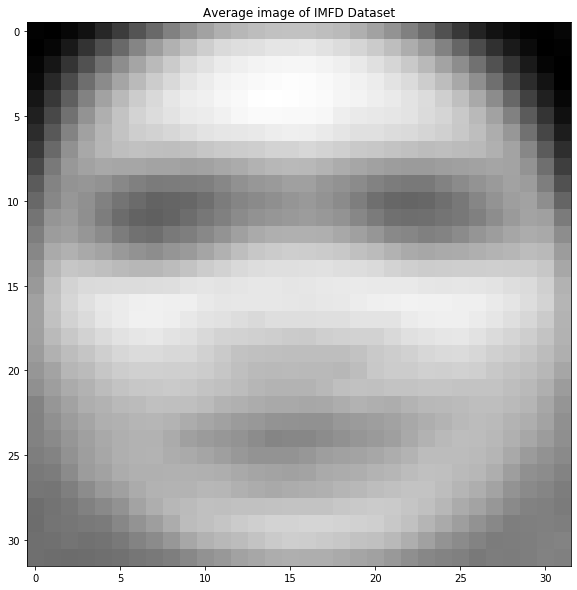

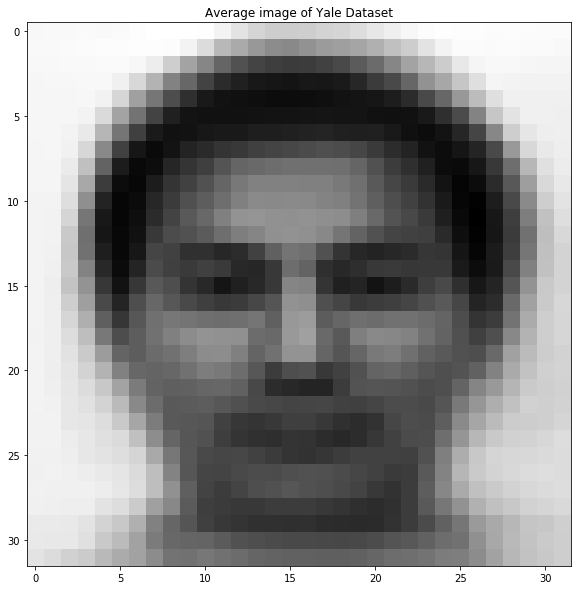

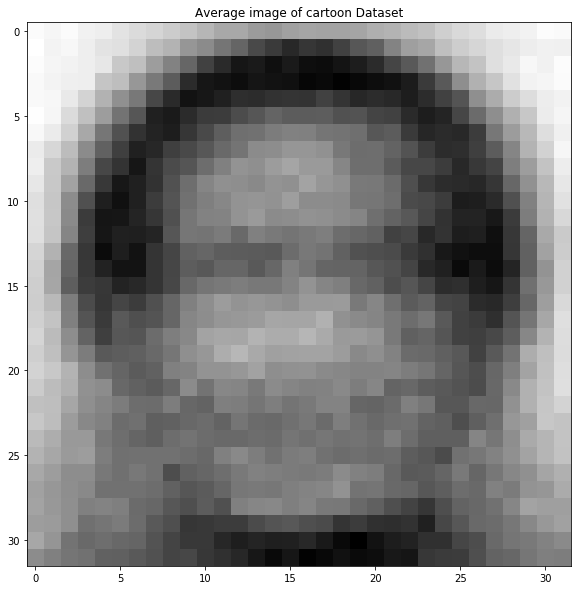

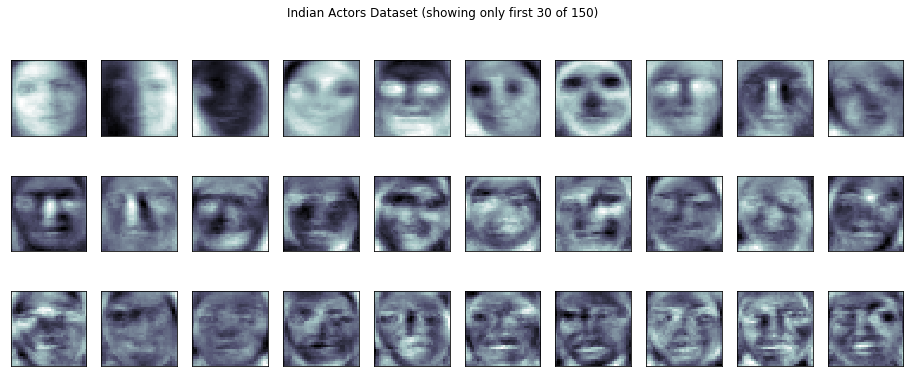

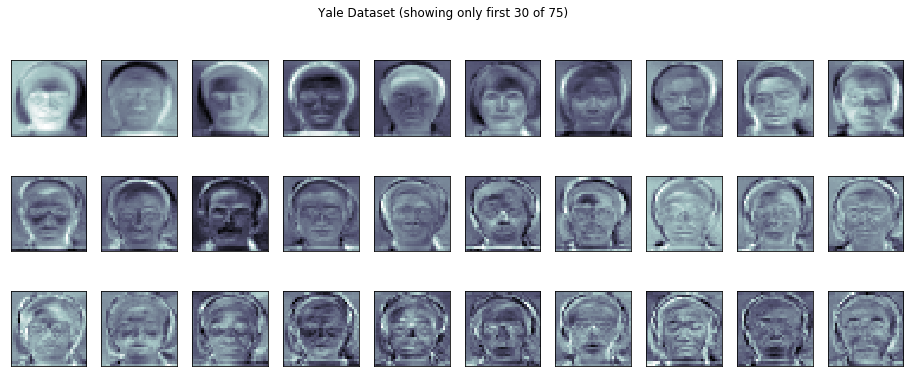

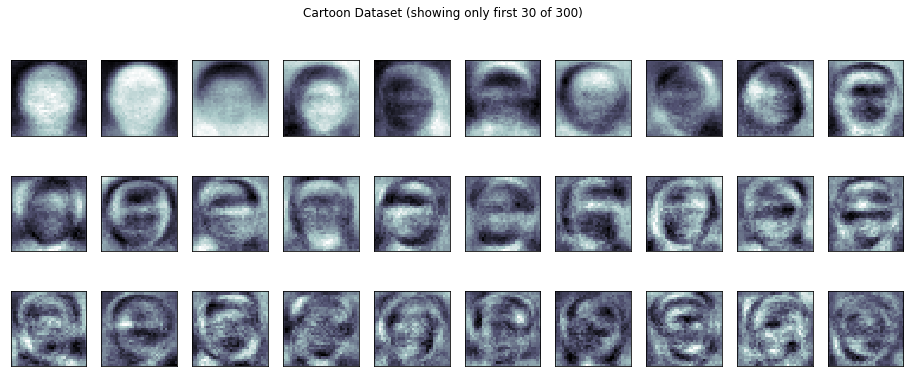

In [117]:
# Compute your features 
# eg.
dirpath1 = './dataset/IMFDB/'
X,y = load_data(dirpath1)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
data1 = X.reshape((N,H*W*C))
X_avg = np.mean(X, axis =0)
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Average image of IMFD Dataset")
ax.imshow(X_avg, cmap = 'gray')

dirpath2 = './dataset/Yale_face_database/'
X_yale,y_yale = load_data(dirpath2)
N_yale,H_yale,W_yale = X_yale.shape[0:3]
C = 1 if opt['is_grayscale'] else X_yale.shape[3]
data2 = X_yale.reshape((N_yale,H_yale*W_yale*C))
X2_avg = np.mean(X_yale, axis =0)
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Average image of Yale Dataset")
ax.imshow(X2_avg, cmap = 'gray')

dirpath3 = './dataset/IIIT-CFW/'
X_cfw,y_cfw = load_data(dirpath3)
N_cfw,H_cfw,W_cfw = X_cfw.shape[0:3]
C = 1 if opt['is_grayscale'] else X_cfw.shape[3]
data3 = X_cfw.reshape((N_cfw,H_cfw*W_cfw*C))
X3_avg = np.mean(X_cfw, axis =0)
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Average image of cartoon Dataset")
ax.imshow(X3_avg, cmap = 'gray')

pca = PCA(150, whiten = True)
pca.fit(data1)
X_3D = pca.transform(data1)
C1 = data1 - np.mean(data1)
eigen_faces1 = pca.components_
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((X.shape[1],X.shape[2])),
              cmap=plt.cm.bone)
fig.suptitle("Indian Actors Dataset (showing only first 30 of 150)")

    
pca = PCA(75, whiten = True)
pca.fit(data2)
X_3D2 = pca.transform(data2)
C2 = data2 - np.mean(data2)
eigen_faces2 = pca.components_
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((X_yale.shape[1],X_yale.shape[2])),
              cmap=plt.cm.bone)
fig.suptitle("Yale Dataset (showing only first 30 of 75)")

    
    
pca = PCA(300, whiten = True)
pca.fit(data3)
X_3D3 = pca.fit_transform(data3)
C3 = data3 - np.mean(data3)
eigen_faces3 = pca.components_
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((X_cfw.shape[1],X_cfw.shape[2])),
              cmap=plt.cm.bone)
fig.suptitle("Cartoon Dataset (showing only first 30 of 300)")


Text(0.5, 0.92, '3D representation of cartoon dataset')

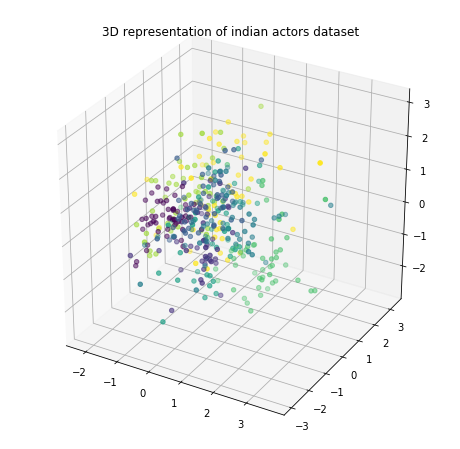

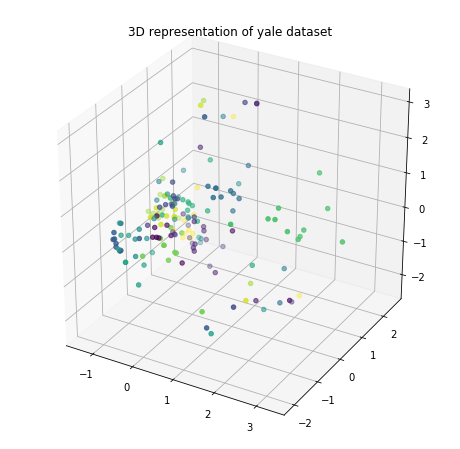

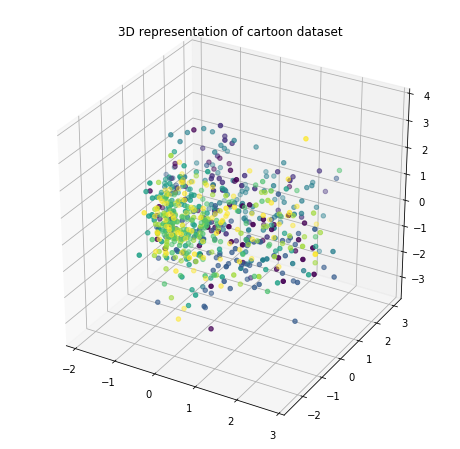

In [118]:
# Create a scatter plot  
# eg.
# print(X_3D.shape)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
ax.set_title("3D representation of indian actors dataset")


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D2[:,0],X_3D2[:,1],X_3D2[:,2],c=y_yale)
ax.set_title("3D representation of yale dataset")


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D3[:,0],X_3D3[:,1],X_3D3[:,2],c=y_cfw)
ax.set_title("3D representation of cartoon dataset")


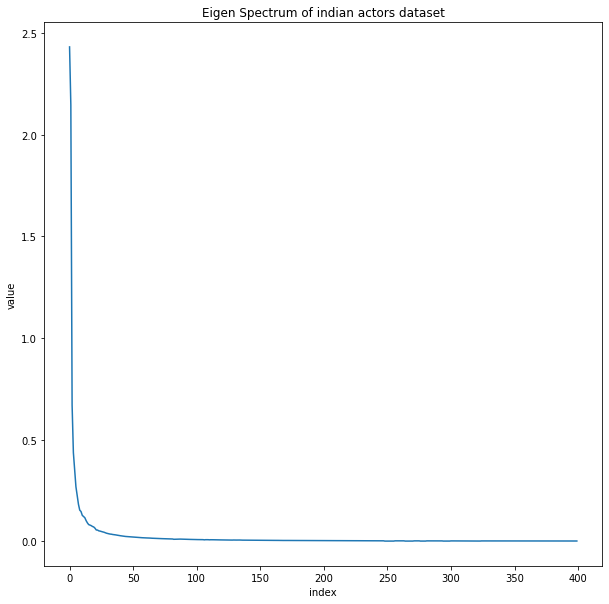

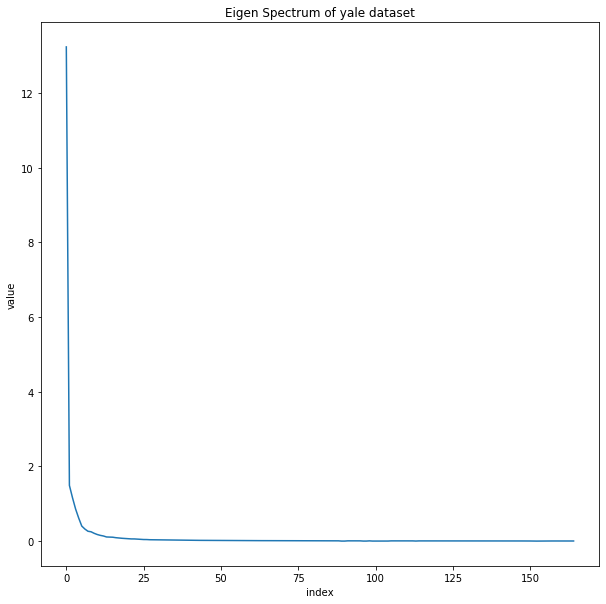

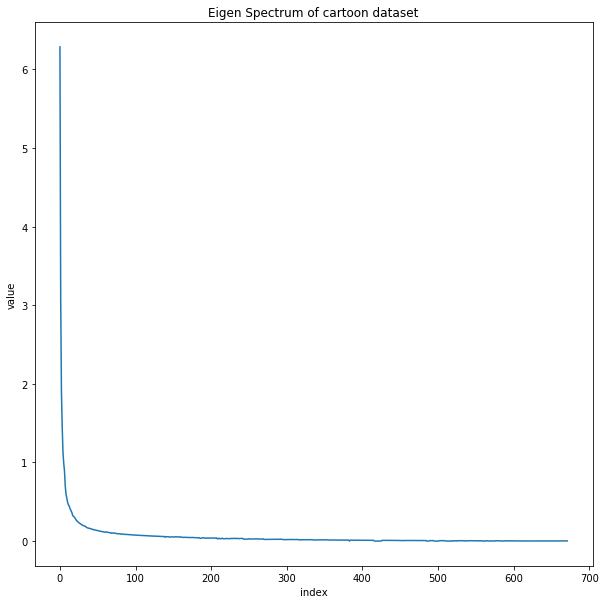

In [119]:
# Plot the eigen value spectrum 
cov = np.cov(data1)
tmpEigVal1,tmpEigVec1=np.linalg.eig(cov)
tmpEigVal1 = np.asarray(tmpEigVal1)
plt.figure()
plt.plot(np.asarray(tmpEigVal1).real)
plt.xlabel("index")
plt.ylabel("value")
plt.title("Eigen Spectrum of indian actors dataset")
plt.show()


cov = np.cov(data2)
tmpEigVal1,tmpEigVec1=np.linalg.eig(cov)
tmpEigVal1 = np.asarray(tmpEigVal1)
plt.figure()
plt.plot(np.asarray(tmpEigVal1).real)
plt.xlabel("index")
plt.ylabel("value")
plt.title("Eigen Spectrum of yale dataset")
plt.show()

cov = np.cov(data3)
tmpEigVal1,tmpEigVec1=np.linalg.eig(cov)
tmpEigVal1 = np.asarray(tmpEigVal1)
plt.figure()
plt.plot(np.asarray(tmpEigVal1).real)
plt.xlabel("index")
plt.ylabel("value")
plt.title("Eigen Spectrum of cartoon dataset")
plt.show()


1(c). Reconstruct  the  image  back for each case


In [120]:
def reconstruct_images(Y, C, M, image_index, h=32, w=32):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image

def plot_portraits(images, titles, name, h=32, w=32, n_row=3, n_col=10):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title("Class: "+str(titles[i]))
        plt.xticks(())
        plt.yticks(())
    plt.suptitle("Reconstructed Images "+str(name))


Reconstruction Error IMFD dataset:  0.030084735817007196
Reconstruction Error YALE dataset:  0.10585337284858605
Reconstruction Error CARTOON dataset:  0.06398541519605822


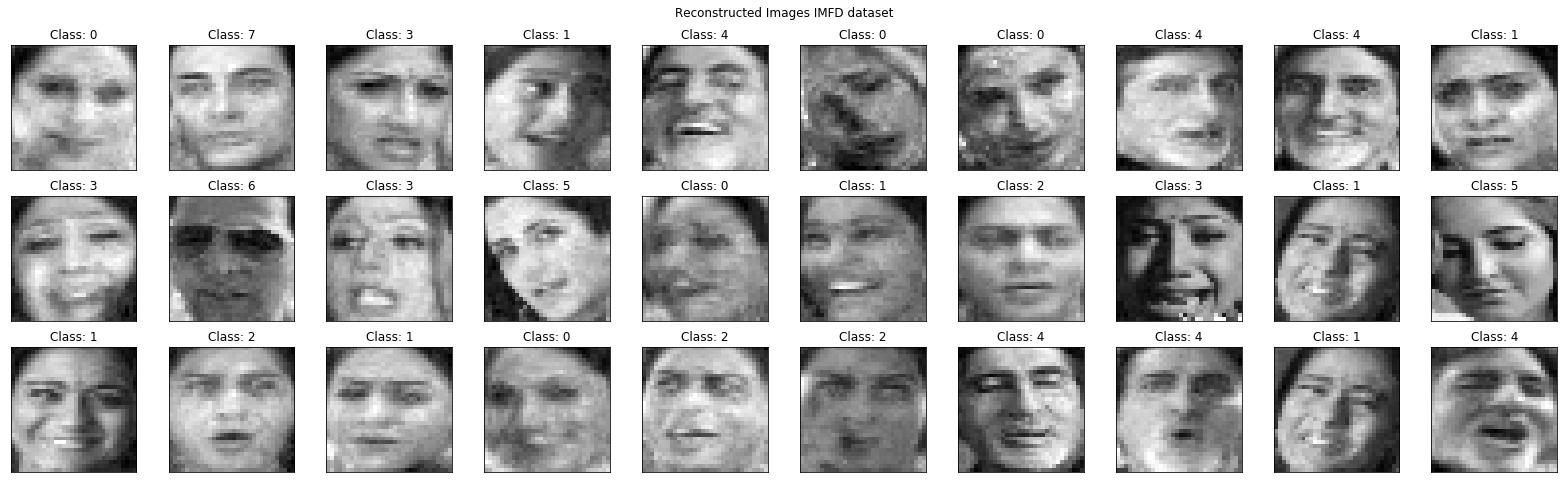

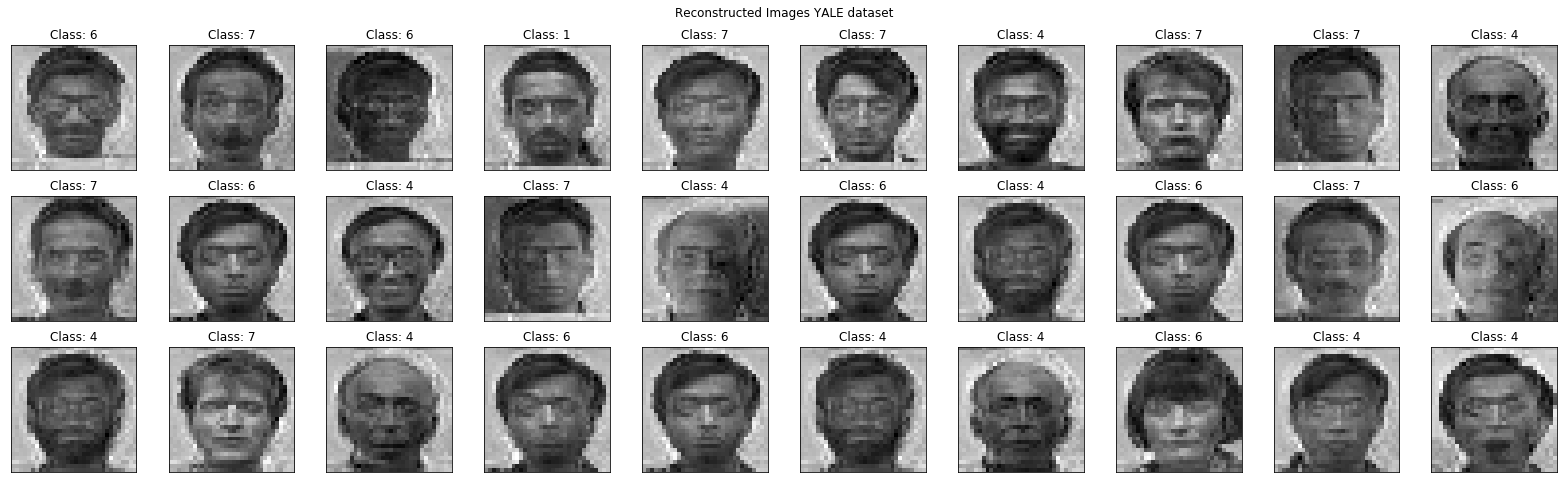

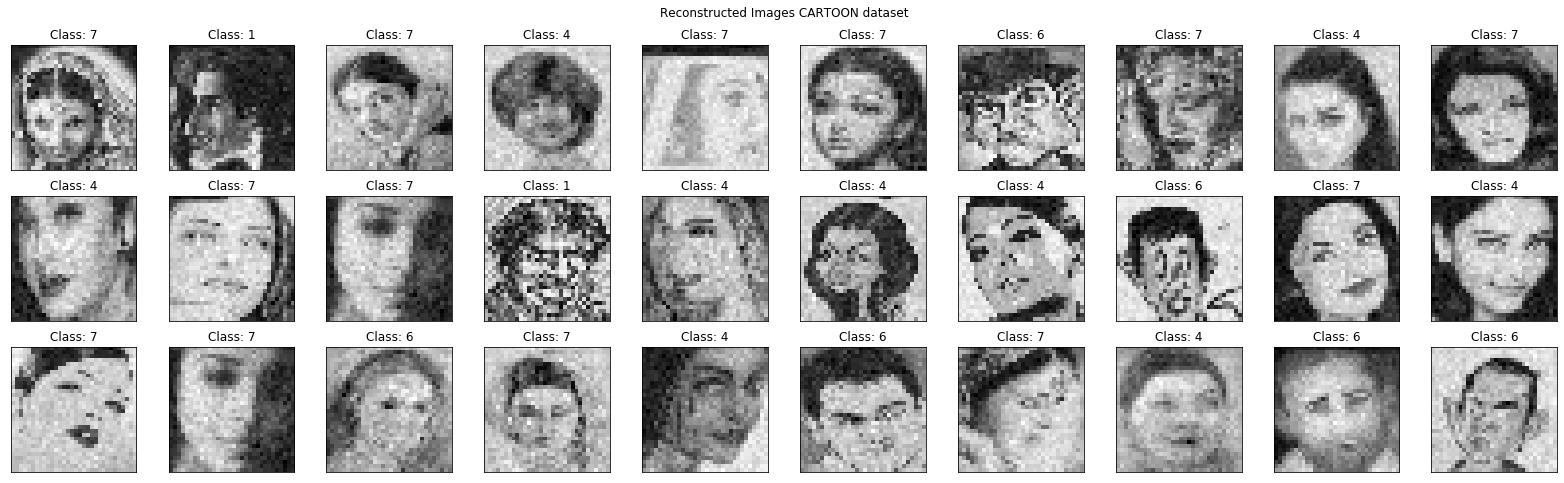

In [124]:
#IMFD
X_reconstructed=[reconstruct_images(C1, eigen_faces1, np.mean(data1),i) for i in range(len(data1))]
# Display random images
ind = np.random.randint(0,y.shape[0],30)
display_images = [X_reconstructed[i] for i in ind]
display_labels = [y[i] for i in ind]
plot_portraits(display_images, display_labels, "IMFD dataset")
# Show the reconstruction error
print("Reconstruction Error IMFD dataset: ",np.sqrt(np.mean((X - X_reconstructed)**2)))


#YALE
X_reconstructed=[reconstruct_images(C2, eigen_faces2, np.mean(data2),i) for i in range(len(data2))]
# Display random images
ind = np.random.randint(0,y_yale.shape[0],30)
display_images = [X_reconstructed[i] for i in ind]
display_labels = [y[i] for i in ind]
plot_portraits(display_images, display_labels, "YALE dataset")
# Show the reconstruction error
print("Reconstruction Error YALE dataset: ",np.sqrt(np.mean((X_yale - X_reconstructed)**2)))


#cartoon
X_reconstructed=[reconstruct_images(C3, eigen_faces3, np.mean(data3),i) for i in range(len(data3))]
# Display random images
ind = np.random.randint(0,y_yale.shape[0],30)
display_images = [X_reconstructed[i] for i in ind]
display_labels = [y[i] for i in ind]
plot_portraits(display_images, display_labels, "CARTOON dataset")

# Show the reconstruction error
print("Reconstruction Error CARTOON dataset: ",np.sqrt(np.mean((X_cfw - X_reconstructed)**2)))



1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [17]:
# code goes here

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore")

# Define your classifier here. You can use libraries like sklearn to create your classifier 
#SVM
class Classifier(SVC):
    def __init__(self,k,cw,c,d,g):
        super().__init__(kernel = k, class_weight = cw, C = c, degree = d, gamma = g)
    
    
    def classify(self,X):
        prediction = self.predict(X)
        
        return prediction
        
    def train(self,X_train,y_train):
        self = self.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        param_grid = {'C': [1e3, 1e5, 1, 10,0.1],
              'gamma': [0.0001, 0.001, 0.005, 0.01, 0.1]}
        self = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid,scoring = 'accuracy').fit(X_validate,y_validate)
        return
#MLP
class mlp_Classifier(MLPClassifier):
    def __init__(self,h,a,iterations):
        super().__init__(hidden_layer_sizes=h,alpha = a, max_iter=iterations)
    
    
    def classify(self,X):
        prediction = self.predict(X)
        return prediction
        
    def train(self,X_train,y_train):
        self = self.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        param_grid = {'alpha': 10.0 ** -np.arange(0, 5)}
        self = GridSearchCV(MLPClassifier(), param_grid,scoring = 'accuracy').fit(X_validate,y_validate)
        return

#plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    
    n=False
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if n else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def test_accuracy(truth,pred):
    return(accuracy_score(truth,pred))

def report_of_classifiaction(truth, predicted):
    return classification_report(truth,predicted)




DATSET 1 : IMFD DATASET:

PCA

SVM:
Validation accuracy before hyper parameter tuning:  0.7375
Validation accuracy after hyper parameter tuning:  1.0

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         7

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Test Accuracy :  1.0

MLP:
Validation accuracy before hyper parameter tuning:  0.5625
Validation accuracy after hyper parameter tuning:  0.6625

CLASSIFACTION REPORT: 
       

Validation accuracy before hyper parameter tuning:  0.3
Validation accuracy after hyper parameter tuning:  1.0

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         7

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Test Accuracy :  1.0

MLP:
Validation accuracy before hyper parameter tuning:  0.9625
Validation accuracy after hyper parameter tuning:  1.0

CLASSIFACTION REPORT: 
              precision    recall  f1-score   sup

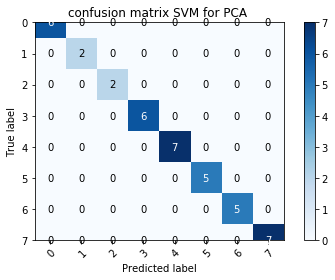

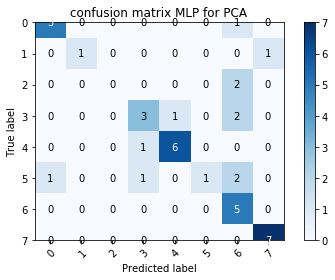

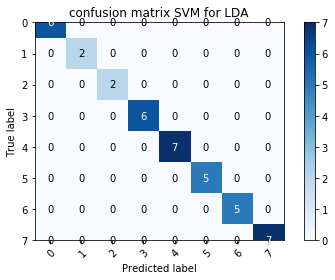

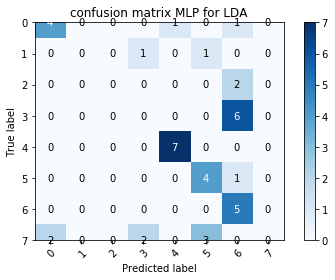

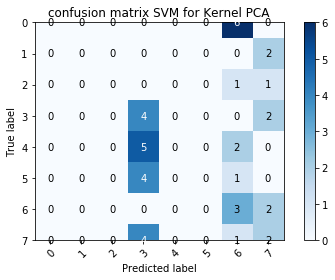

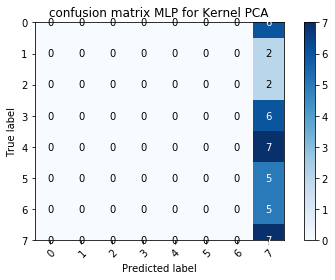

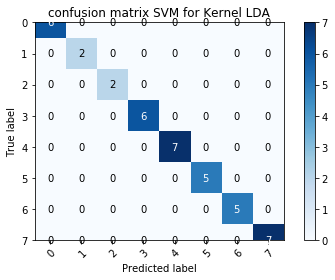

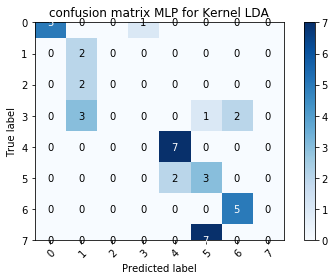

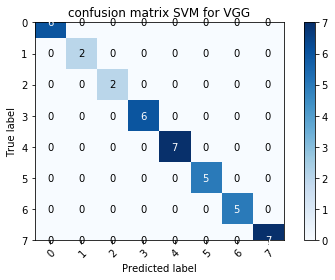

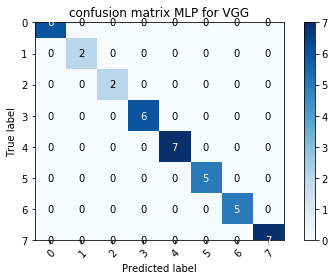

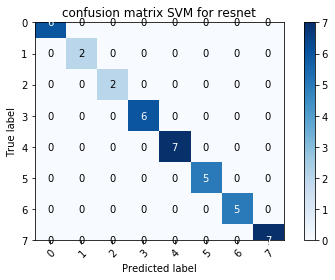

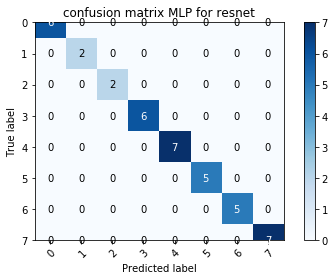

In [19]:
# Create a train and validation split to train your classifier 
print("DATSET 1 : IMFD DATASET:")
print("\nPCA")
names = np.unique(y)
data = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
data_pca = get_pca(data, 150)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_pca, y, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_pca, y, test_size=0.20, random_state=42)

print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for PCA ')


#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for PCA')


print("\n\nLDA")
data_lda = get_lda(data,y, len(names) -1)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_lda, y, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_lda, y, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for LDA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for LDA')


print("\n\nKernel_PCA")
data_kpca = get_kernel_pca(data,150)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_kpca, y, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_kpca, y, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for Kernel PCA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for Kernel PCA')



print("\n\nKernel_LDA")
data_kpca = get_kernel_lda(data,y,len(names)-1)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_kpca, y, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_kpca, y, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for Kernel LDA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for Kernel LDA')


print("\n\nVGG")
data_vgg = get_vgg_features(dirpath1)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_vgg, y, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_vgg, y, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for VGG')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for VGG')


print("\n\nRESNET")
data_resnet = get_resnet_features(dirpath1)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_resnet, y, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_resnet, y, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for resnet')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for resnet')


DATSET 2 : YALE DATASET:

PCA

SVM:
Validation accuracy before hyper parameter tuning:  0.48484848484848486
Validation accuracy after hyper parameter tuning:  1.0

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1

    accuracy                           1.00        17
 

Validation accuracy before hyper parameter tuning:  0.0
Validation accuracy after hyper parameter tuning:  1.0

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17

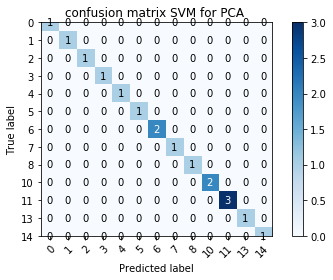

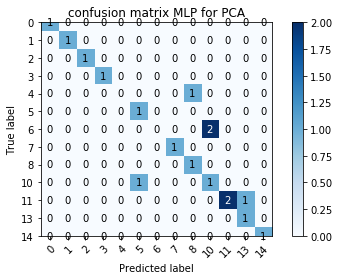

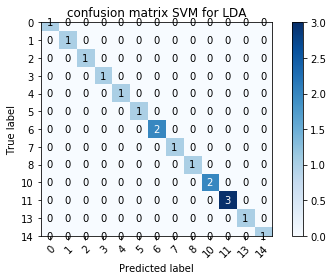

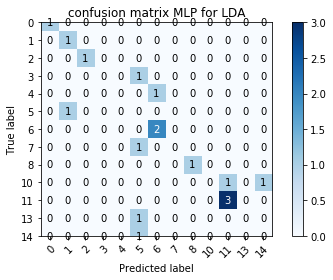

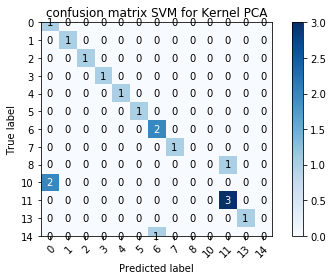

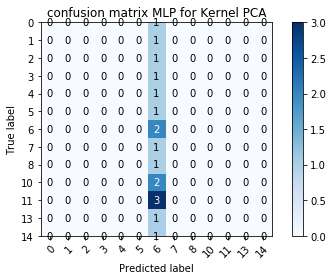

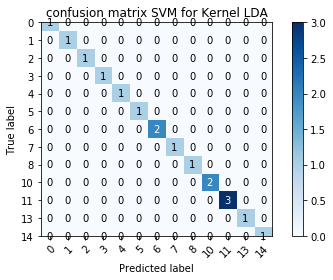

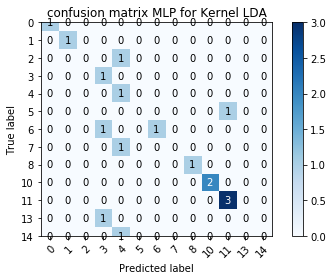

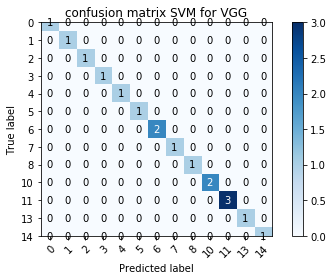

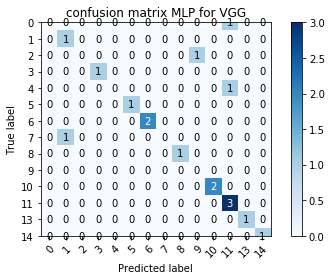

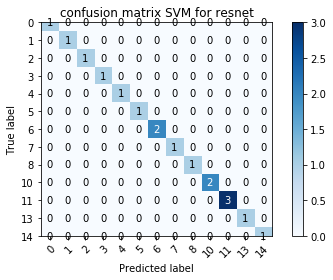

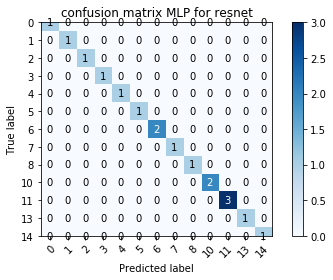

In [20]:
print("DATSET 2 : YALE DATASET:")
print("\nPCA")
names = np.unique(y_yale)
data = X_yale.reshape((X_yale.shape[0],X_yale.shape[1]*X_yale.shape[2]))
data_pca = get_pca(data, 75)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_pca, y_yale, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_pca, y_yale, test_size=0.20, random_state=42)

print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for PCA ')


#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for PCA')


print("\n\nLDA")
data_lda = get_lda(data,y_yale, len(names) -1)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_lda, y_yale, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_lda, y_yale, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for LDA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for LDA')


print("\n\nKernel_PCA")
data_kpca = get_kernel_pca(data,75)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_kpca, y_yale, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_kpca, y_yale, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for Kernel PCA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for Kernel PCA')



print("\n\nKernel_LDA")
data_kpca = get_kernel_lda(data,y_yale,len(names)-1)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_kpca, y_yale, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_kpca, y_yale, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for Kernel LDA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for Kernel LDA')


print("\n\nVGG")
data_vgg = get_vgg_features(dirpath2)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_vgg, y_yale, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_vgg, y_yale, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for VGG')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for VGG')


print("\n\nRESNET")
data_resnet = get_resnet_features(dirpath2)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_resnet, y_yale, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_resnet, y_yale, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for resnet')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for resnet')




DATSET 3 : CARTOON DATASET:

PCA

SVM:
Validation accuracy before hyper parameter tuning:  0.14074074074074075
Validation accuracy after hyper parameter tuning:  1.0

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        15

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68

Test Accuracy :  1.0

MLP:
Validation accuracy before hyper parameter tuning:  0.4
Validation accuracy after hyper parameter tuning:  0.6962962962962963

CLASS

Validation accuracy before hyper parameter tuning:  0.43703703703703706
Validation accuracy after hyper parameter tuning:  1.0

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        15

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68

Test Accuracy :  1.0

MLP:
Validation accuracy before hyper parameter tuning:  0.9777777777777777
Validation accuracy after hyper parameter tuning:  0.762962962962963

CLASSIFACTION REPORT: 
       

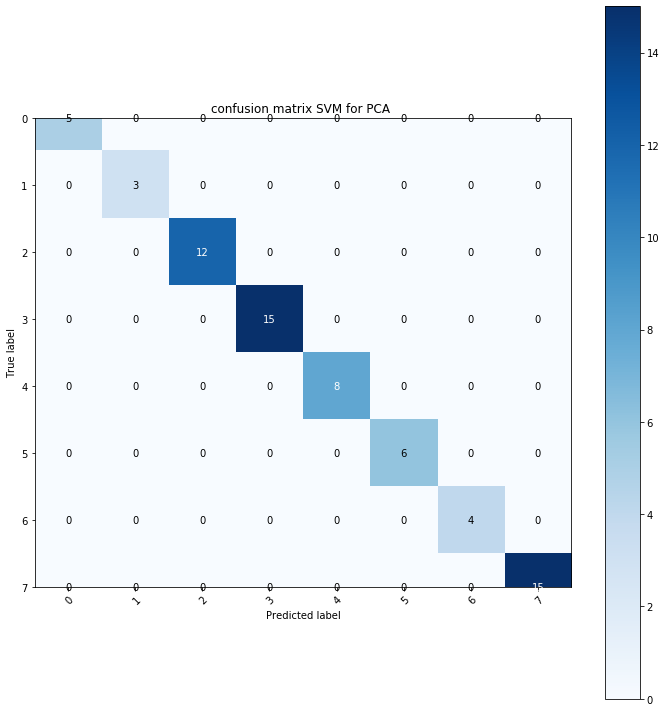

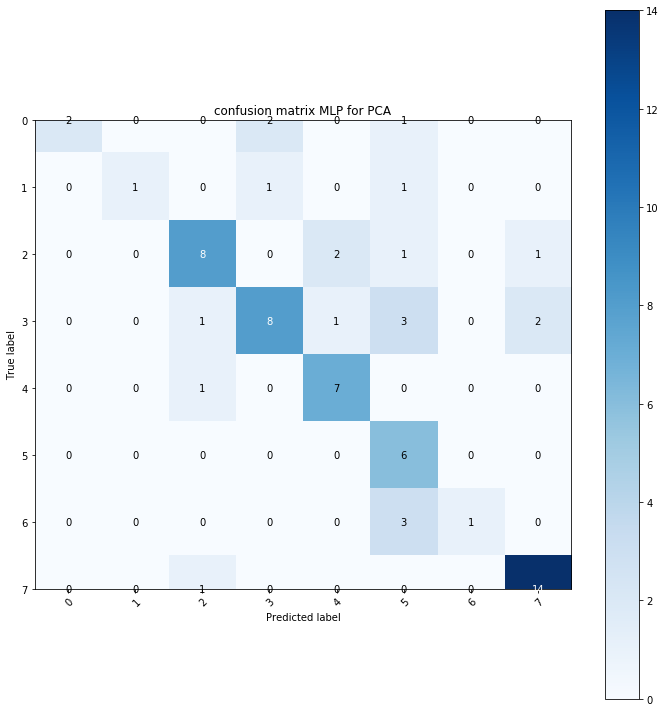

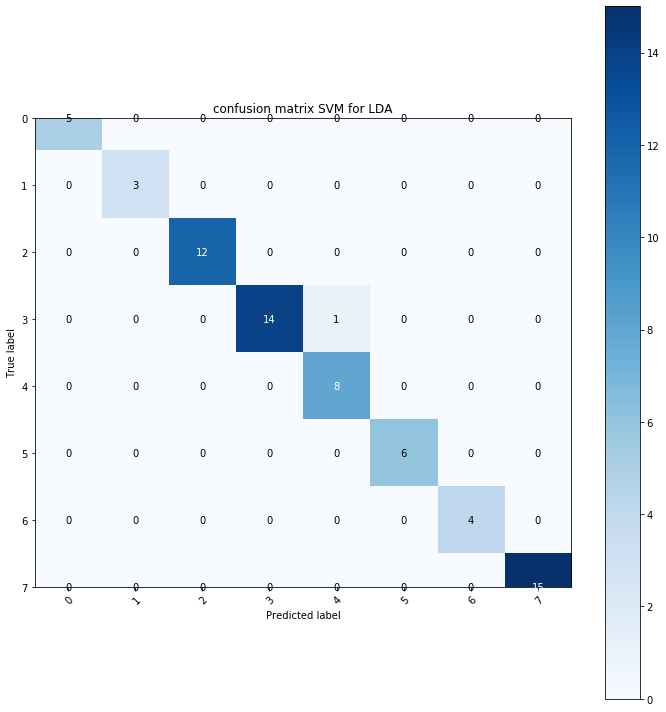

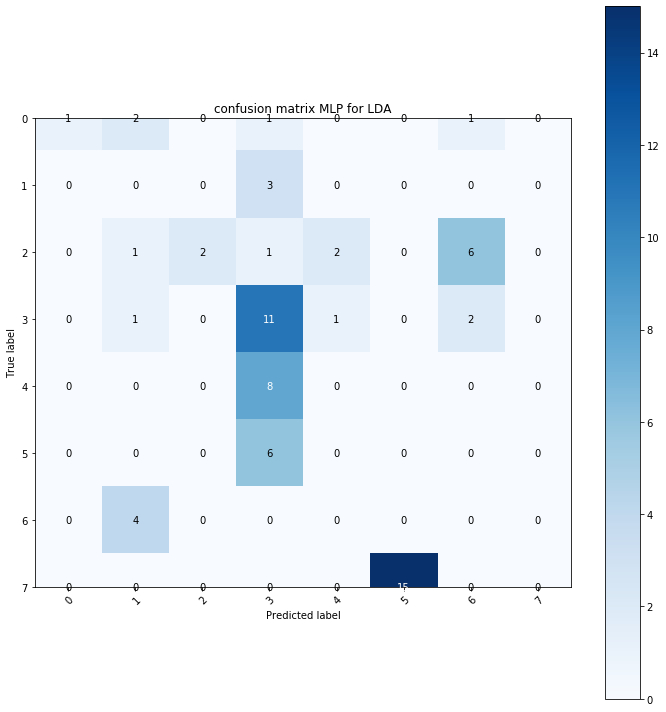

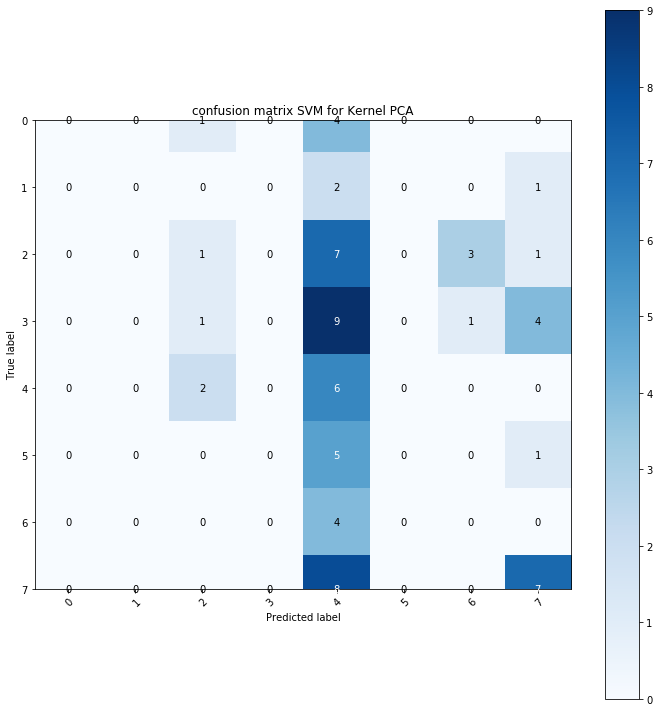

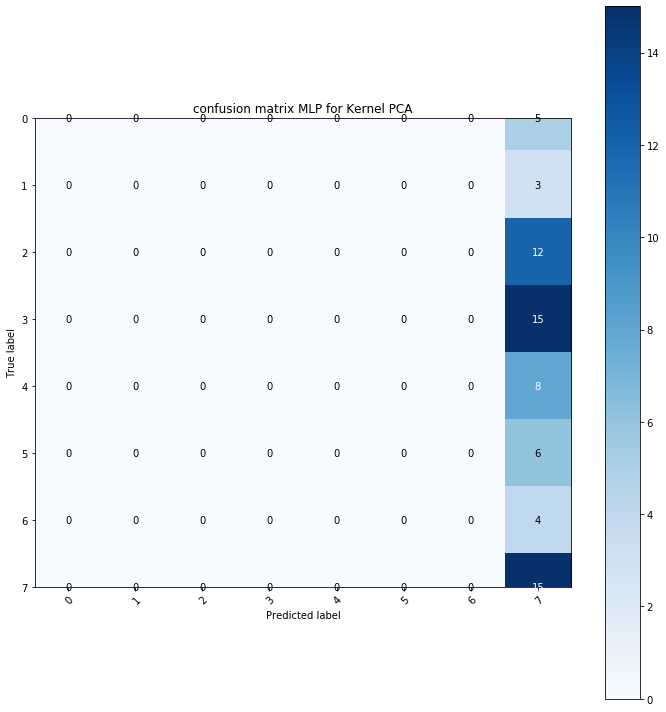

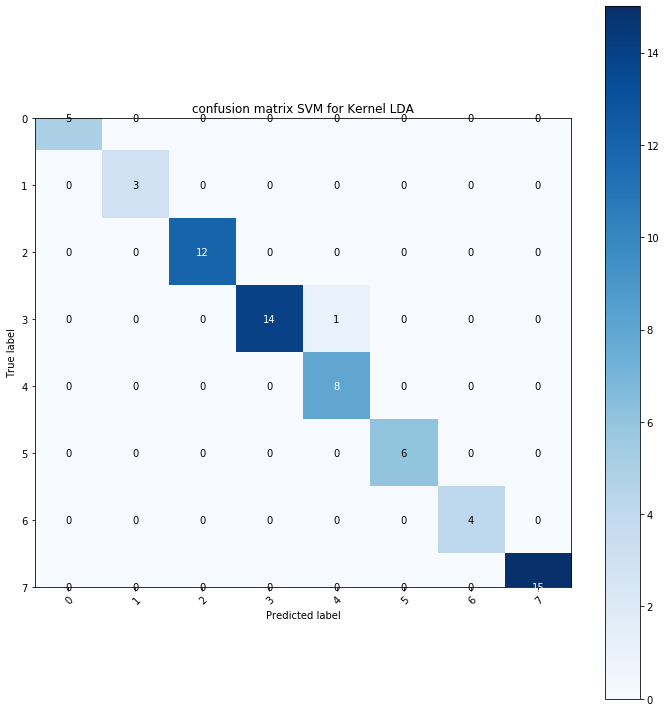

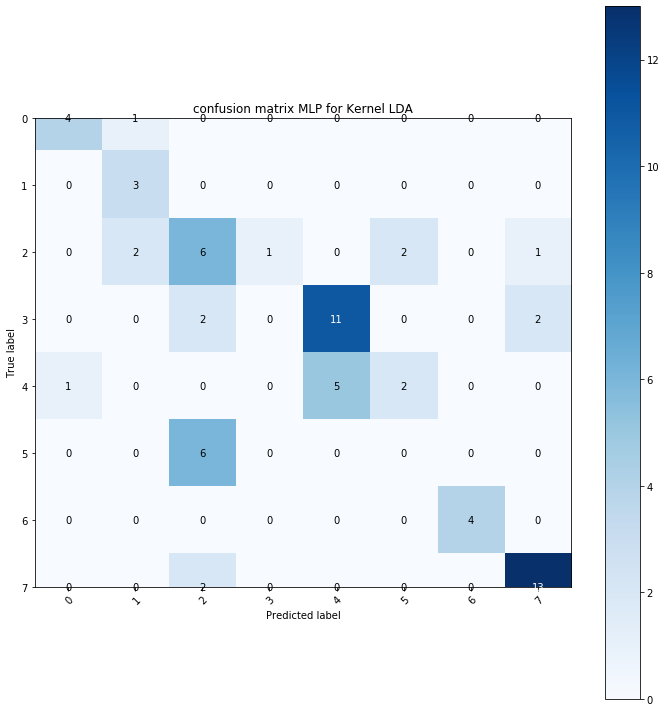

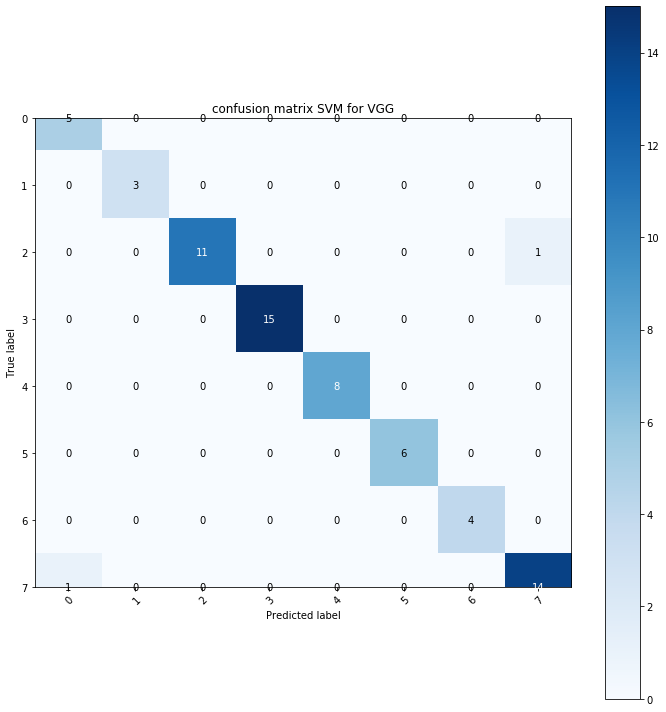

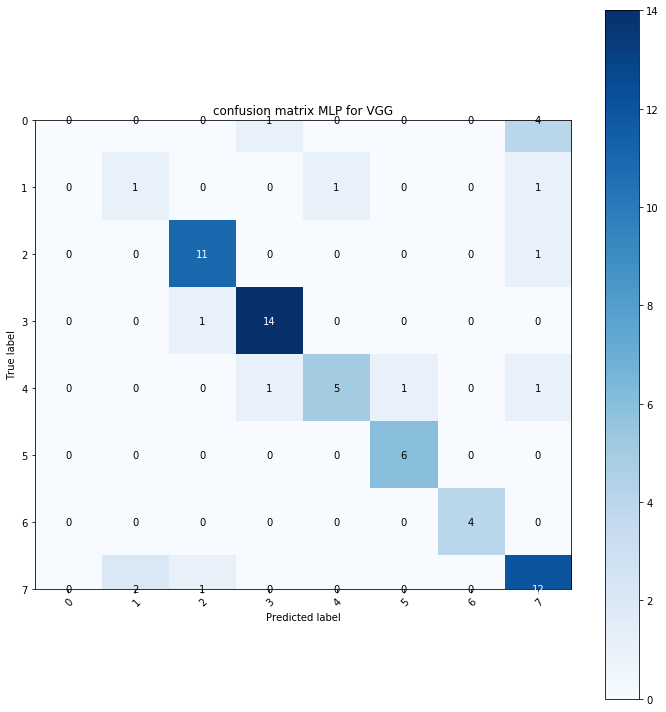

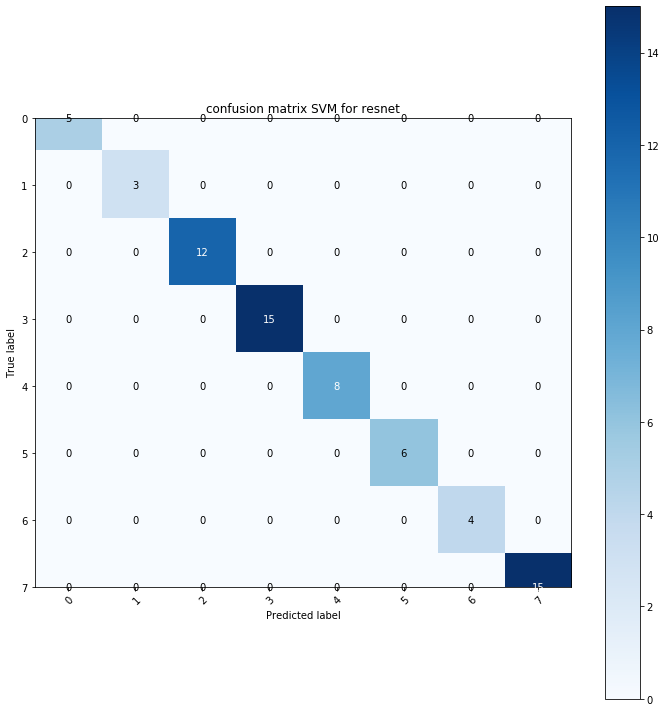

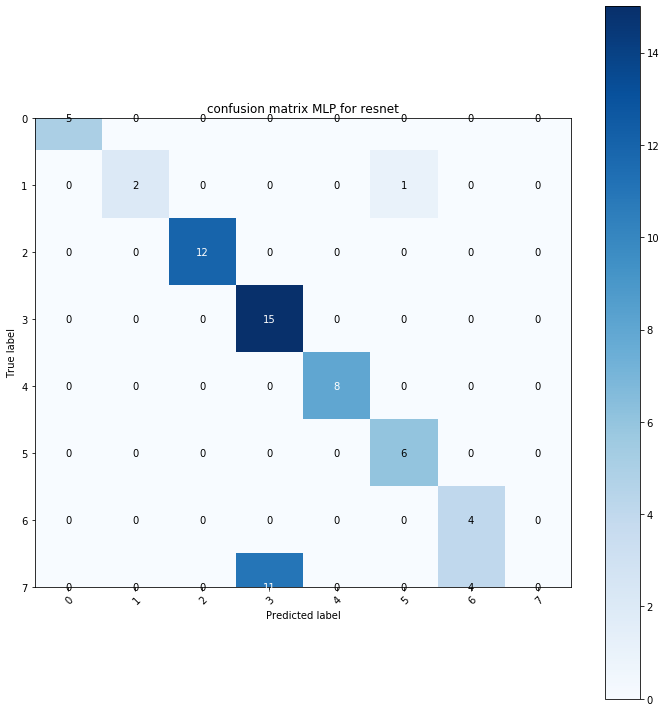

In [51]:
print("DATSET 3 : CARTOON DATASET:")
print("\nPCA")
names = np.unique(y_cfw)
data = X_cfw.reshape((X_cfw.shape[0],X_cfw.shape[1]*X_cfw.shape[2]))
data_pca = get_pca(data, 200)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_pca, y_cfw, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_pca, y_cfw, test_size=0.20, random_state=42)

print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for PCA ')


#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for PCA')


print("\n\nLDA")
data_lda = get_lda(data,y_cfw, len(names) -1)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_lda, y_cfw, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_lda, y_cfw, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for LDA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for LDA')


print("\n\nKernel_PCA")
data_kpca = get_kernel_pca(data,300)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_kpca, y_cfw, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_kpca, y_cfw, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for Kernel PCA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for Kernel PCA')



print("\n\nKernel_LDA")
data_kpca = get_kernel_lda(data,y_cfw,len(names)-1)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_kpca, y_cfw, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_kpca, y_cfw, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for Kernel LDA')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for Kernel LDA')


print("\n\nVGG")
data_vgg = get_vgg_features(dirpath3)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_vgg, y_cfw, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_vgg, y_cfw, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for VGG')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for VGG')



print("\n\nRESNET")
data_resnet = get_resnet_features(dirpath3)
X_train1, X_test1, y_train1, y_test1 = train_test_split( data_resnet, y_cfw, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data_resnet, y_cfw, test_size=0.20, random_state=42)
print("\nSVM:")
#SVM
clf = Classifier(k='rbf', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix SVM for resnet')

#MLP
print("\nMLP:")
clf = mlp_Classifier(h=(10,),a= 1, iterations=100)
clf.train(X_train1, y_train1)
val1 = clf.classify(X_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
val1 = clf.classify(X_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.classify(X_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix MLP for resnet')


In [50]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)


In [23]:
# For each dataset print the confusion matrix for the best model 

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.
## Ans:
For the Yale Dataset we observe a decent distinction between classes owing to its fewer features compared to the other two.

Text(0.5, 1, 'CARTOON DATASET')

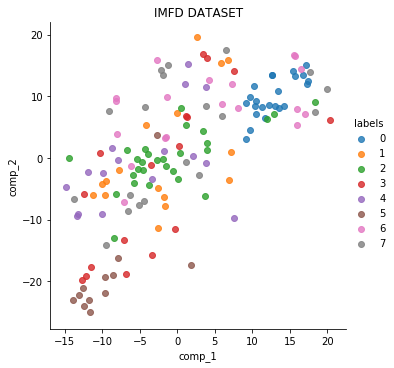

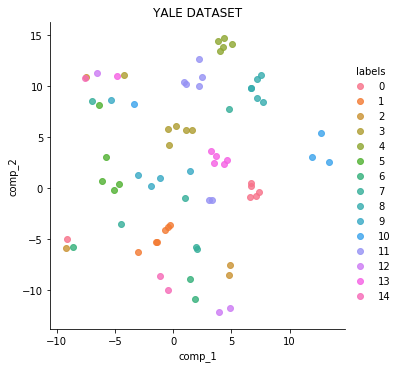

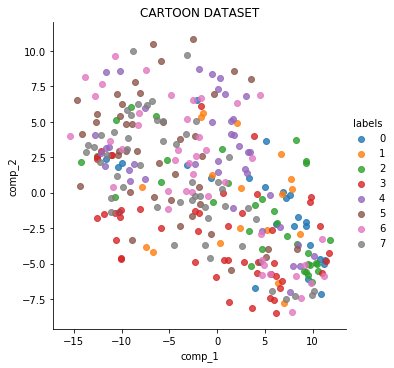

In [24]:
# Compute TSNE for different features and create a scatter plot
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#IMFD
data = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
k = 2 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(data)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

proj = pd.DataFrame(X_TSNE)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y

sns.lmplot("comp_1", "comp_2", hue = "labels", data = proj.sample(150,replace = False) ,fit_reg=False)
ax = plt.gca()
ax.set_title("IMFD DATASET")


#yale
data = X_yale.reshape((X_yale.shape[0],X_yale.shape[1]*X_yale.shape[2]))
k = 2 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(data)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

proj = pd.DataFrame(X_TSNE)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_yale

sns.lmplot("comp_1", "comp_2", hue = "labels", data = proj.sample(75,replace = False) ,fit_reg=False)
ax = plt.gca()
ax.set_title("YALE DATASET")


#cartoon
data = X_cfw.reshape((X_cfw.shape[0],X_cfw.shape[1]*X_cfw.shape[2]))
k = 2 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(data)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

proj = pd.DataFrame(X_TSNE)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_cfw

sns.lmplot("comp_1", "comp_2", hue = "labels", data = proj.sample(300,replace = False) ,fit_reg=False)
ax = plt.gca()
ax.set_title("CARTOON DATASET")


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [25]:
from sklearn.neighbors import KNeighborsClassifier

class FaceVerification(KNeighborsClassifier):
    def __init__(self,k,cw,distance_type):
        super().__init__(n_neighbors = k, weights = cw, p = distance_type)
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,y):
        verification_results = np.ones(y.shape, dtype=bool)
        prediction = self.predict(X)
        i = 0
        for x, pred, label in zip(X, prediction, y):
            if pred != label:
                verification_results[i] = False
            i +=1
        return prediction
        
    def train(self,X_train,y_train):
        self = self.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        param_grid = {'n_neighbors': np.arange(1, 35), 'weights': ['uniform','distance'], 'p':[1,2,3]}        
        GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1).fit(X_validate,y_validate)
        return
        


DATSET 1 : IMFD DATASET:

KNN
Validation accuracy before hyper parameter tuning:  0.4375
Validation accuracy after hyper parameter tuning:  0.625

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.29      1.00      0.44         2
           2       0.67      1.00      0.80         2
           3       0.80      0.67      0.73         6
           4       0.75      0.43      0.55         7
           5       0.60      0.60      0.60         5
           6       0.80      0.80      0.80         5
           7       1.00      0.43      0.60         7

    accuracy                           0.68        40
   macro avg       0.71      0.74      0.67        40
weighted avg       0.76      0.68      0.68        40

Test Accuracy :  0.675


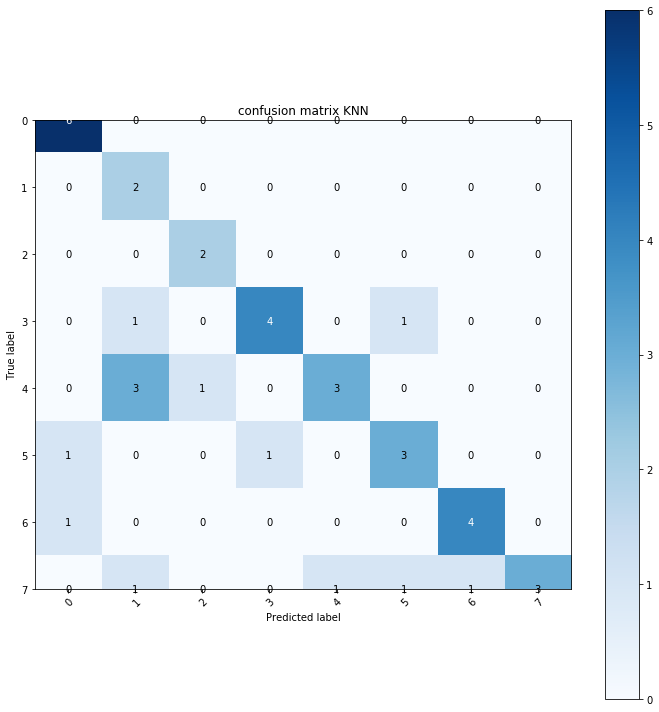

In [26]:
# Create a train and validation split and show your results 
print("DATSET 1 : IMFD DATASET:")
print("\nKNN")
names = np.unique(y)
data = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
X_train1, X_test1, y_train1, y_test1 = train_test_split( data, y, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data, y, test_size=0.40, random_state=42)

pca = PCA(150)
pca.fit(X_train1)
X_train_pca1 = pca.transform(X_train1)
X_test_pca1 = pca.transform(X_test1)
X_val_pca1 = pca.transform(X_val1)

clf = FaceVerification(k = 5 , cw = 'uniform', distance_type = 2)
clf.train(X_train_pca1, y_train1)
val1 = clf.verify(X_val_pca1,y_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val_pca1, y_val1)
clf.train(X_val_pca1, y_val1)
val1 = clf.verify(X_val_pca1, y_test1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.verify(X_test_pca1, y_val1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix KNN')



DATSET 2 : YALE DATASET:

KNN
Validation accuracy before hyper parameter tuning:  0.6818181818181818
Validation accuracy after hyper parameter tuning:  0.7878787878787878

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.33      1.00      0.50         1
           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       0.75      1.00      0.86         3
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00         1

    accuracy                           0.76    

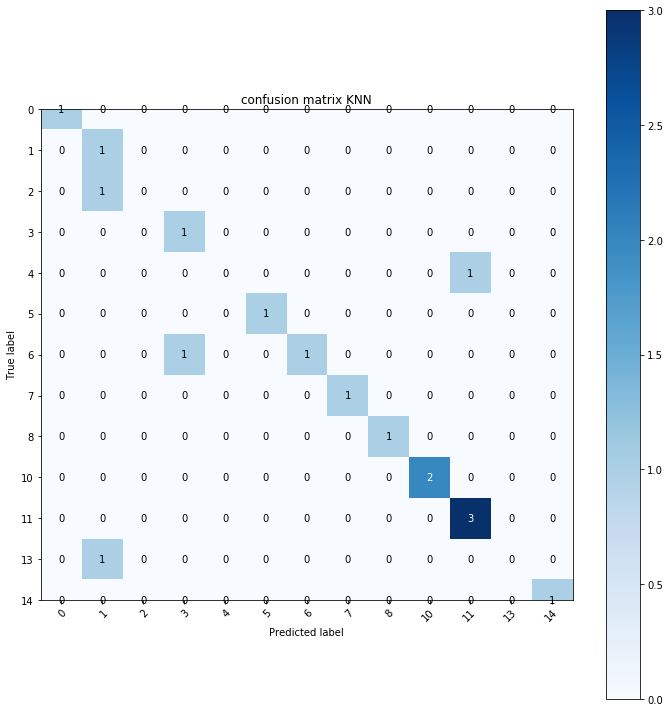

In [27]:
print("DATSET 2 : YALE DATASET:")
print("\nKNN")
names = np.unique(y_yale)
data = X_yale.reshape((X_yale.shape[0],X_yale.shape[1]*X_yale.shape[2]))
X_train1, X_test1, y_train1, y_test1 = train_test_split( data, y_yale, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data, y_yale, test_size=0.40, random_state=42)

pca = PCA(75)
pca.fit(X_train1)
X_train_pca1 = pca.transform(X_train1)
X_test_pca1 = pca.transform(X_test1)
X_val_pca1 = pca.transform(X_val1)

clf = FaceVerification(k = 5 , cw = 'uniform', distance_type = 2)
clf.train(X_train_pca1, y_train1)
val1 = clf.verify(X_val_pca1,y_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val_pca1, y_val1)
clf.train(X_val_pca1, y_val1)
val1 = clf.verify(X_val_pca1, y_test1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.verify(X_test_pca1, y_val1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix KNN')


DATSET 3 : CARTOON DATASET:

KNN
Validation accuracy before hyper parameter tuning:  0.3754646840148699
Validation accuracy after hyper parameter tuning:  0.5278810408921933

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.33      0.67      0.44         3
           2       0.50      0.50      0.50        12
           3       0.60      0.60      0.60        15
           4       0.60      0.75      0.67         8
           5       0.38      0.50      0.43         6
           6       1.00      0.75      0.86         4
           7       0.57      0.27      0.36        15

    accuracy                           0.53        68
   macro avg       0.55      0.58      0.55        68
weighted avg       0.56      0.53      0.52        68

Test Accuracy :  0.5294117647058824


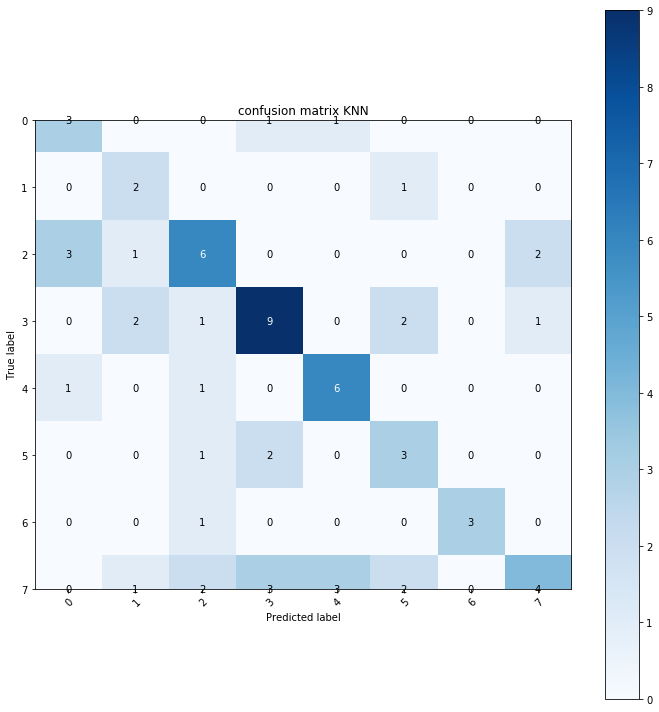

In [28]:
print("DATSET 3 : CARTOON DATASET:")
print("\nKNN")
names = np.unique(y_cfw)
data = X_cfw.reshape((X_cfw.shape[0],X_cfw.shape[1]*X_cfw.shape[2]))
X_train1, X_test1, y_train1, y_test1 = train_test_split( data, y_cfw, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( data, y_cfw, test_size=0.40, random_state=42)

pca = PCA(75)
pca.fit(X_train1)
X_train_pca1 = pca.transform(X_train1)
X_test_pca1 = pca.transform(X_test1)
X_val_pca1 = pca.transform(X_val1)

clf = FaceVerification(k = 5 , cw = 'uniform', distance_type = 2)
clf.train(X_train_pca1, y_train1)
val1 = clf.verify(X_val_pca1,y_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val_pca1, y_val1)
clf.train(X_val_pca1, y_val1)
val1 = clf.verify(X_val_pca1, y_test1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

y_pred1 = clf.verify(X_test_pca1, y_val1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names,title = 'confusion matrix KNN')


In [29]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

Labels for real images = 0
Labels for cartoon images = 1


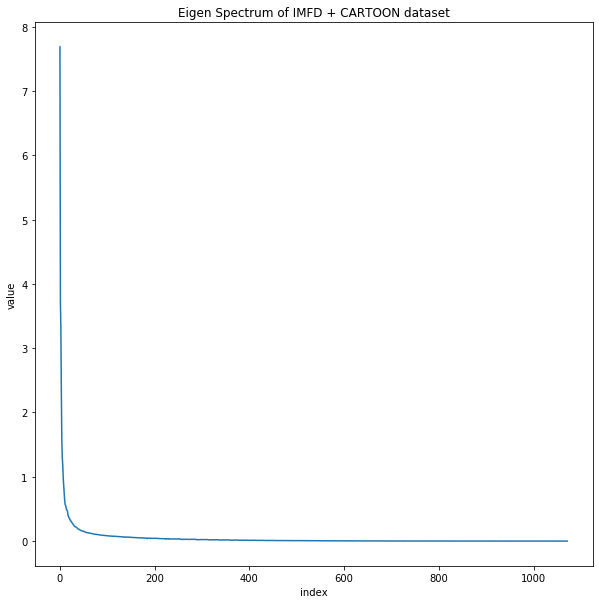

In [54]:
# Load data
# print(X.shape, X_cfw.shape)
y1 = np.zeros(y.shape,dtype=int)
y2 = np.ones(y_cfw.shape,dtype=int)
data = np.concatenate((X, X_cfw), axis = 0)
data = data.reshape(data.shape[0],data.shape[1]*data.shape[2])
labels = np.concatenate((y1, y2), axis = 0)
print("Labels for real images = 0")
print("Labels for cartoon images = 1")

cov = np.cov(data)
tmpEigVal1,tmpEigVec1=np.linalg.eig(cov)
tmpEigVal1 = np.asarray(tmpEigVal1)
plt.figure()
plt.plot(np.asarray(tmpEigVal1).real)
plt.xlabel("index")
plt.ylabel("value")
plt.title("Eigen Spectrum of IMFD + CARTOON dataset")
plt.show()





In [61]:
names = np.unique(labels)
print(names)
data_lda = get_pca(data,400)
# #splitting data into train, test, validaton sets
train1, X_test1, train_labels, y_test1 = train_test_split( data_lda, labels, test_size=0.10, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split( train1, train_labels, test_size=0.40, random_state=19)



[0 1]


CARTOON VS REAL:

Validation accuracy before hyper parameter tuning:  0.9455958549222798
Validation accuracy after hyper parameter tuning:  1.0

CLASSIFACTION REPORT: 
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        41
           1       1.00      0.90      0.94        67

    accuracy                           0.94       108
   macro avg       0.93      0.95      0.93       108
weighted avg       0.94      0.94      0.94       108

Test Accuracy :  0.9351851851851852


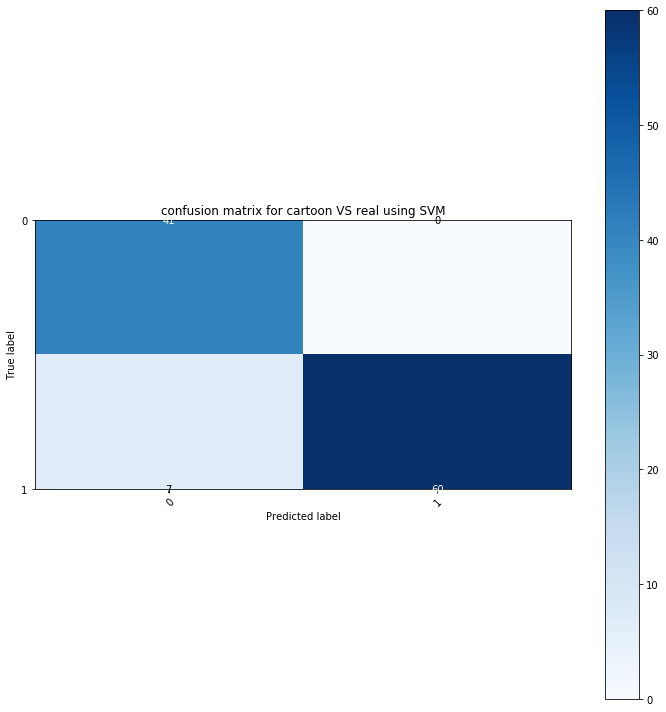

In [63]:
# Create your classifier
class CartoonVSreal(SVC):
    def __init__(self,k,cw,c,d,g):
        super().__init__(kernel = k, class_weight = cw, C = c, degree = d, gamma = g)
    
    
    def classify(self,X,y):
        verification_results = np.ones(y.shape, dtype=bool)
        prediction = self.predict(X)
        i = 0
        for x, pred, label in zip(X, prediction, y):
            if pred != label:
                verification_results[i] = False
            i +=1
        
        return verification_results, prediction
        
    def train(self,X_train,y_train):
        self = self.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1, 10,0.1,0.001],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
        self = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), param_grid).fit(X_validate,y_validate)
#         print(self.best_estimator_)
        return
print("CARTOON VS REAL:\n")
clf = CartoonVSreal(k='linear', cw = 'balanced', c = 1, d = 3, g = 0.1)
clf.train(X_train1, y_train1)
results,val1 = clf.classify(X_val1,y_val1)
print("Validation accuracy before hyper parameter tuning: ",test_accuracy(y_val1,val1))

clf.validate(X_val1, y_val1)
clf.train(X_val1, y_val1)
results,val1 = clf.classify(X_val1,y_val1)
print("Validation accuracy after hyper parameter tuning: ",test_accuracy(y_val1,val1))

results, y_pred1 = clf.classify(X_test1,y_test1)
print('\nCLASSIFACTION REPORT: ')
print(report_of_classifiaction(y_test1, y_pred1))
print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))

plot_confusion_matrix(y_test1, y_pred1, names, title = 'confusion matrix for cartoon VS real using SVM')

Test Accuracy :  0.9351851851851852

K-fold Cross validation score with 5 splits: [0.95336788 0.94818653 0.97409326 0.94818653 0.91666667]


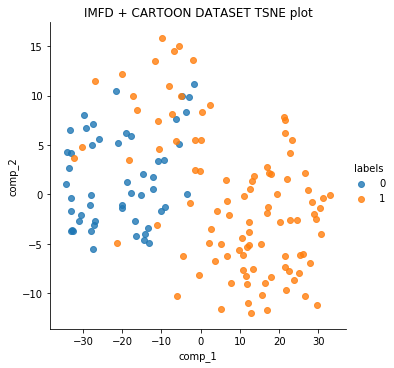

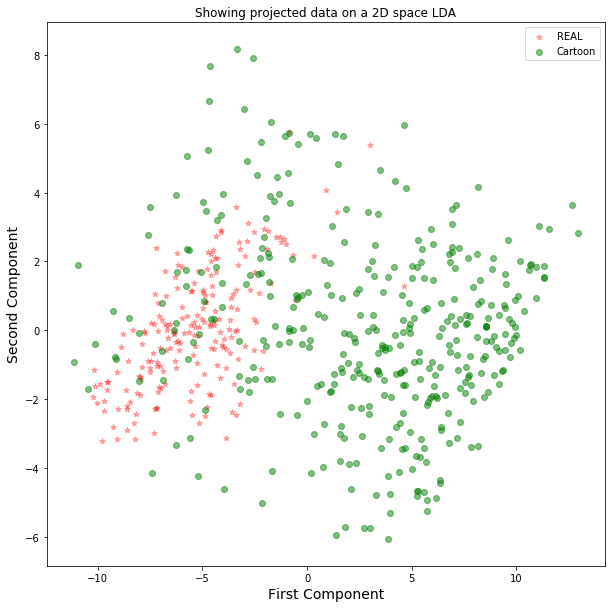

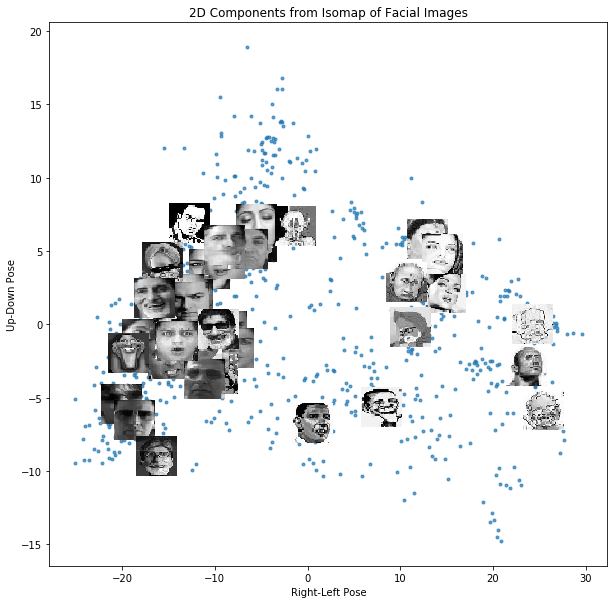

In [65]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc. 
from sklearn import manifold

print("Test Accuracy : ", test_accuracy(y_test1, y_pred1))
print("\nK-fold Cross validation score with 5 splits:", cross_val_score(SVC(kernel = 'linear', C = 0.1, gamma=0.0001), train1, train_labels, cv = 5, scoring = 'accuracy' ))

X_TSNE = TSNE(n_components=k).fit_transform(data)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)


proj = pd.DataFrame(X_TSNE)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = labels
sns.lmplot("comp_1", "comp_2", hue = "labels", data = proj.sample(150,replace = False) ,fit_reg=False)
ax = plt.gca()
ax.set_title("IMFD + CARTOON DATASET TSNE plot")

Xax=X_train1[:,0]
Yax=X_train1[:,1]
label=y_train1
cdict={0:'red',1:'green'}
labl={0:'REAL',1:'Cartoon'}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots()
fig.patch.set_facecolor('white')
for l in np.unique(label):
         ix=np.where(label==l)
         ax.scatter(Xax[ix], Yax[ix],c=cdict[l],label=labl[l],marker=marker[l],alpha=alpha[l])
plt.xlabel("First Component",fontsize=14)
plt.ylabel("Second Component",fontsize=14)
plt.legend()
plt.title("Showing projected data on a 2D space LDA")
plt.show()


iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(data)
manifold_2Da = iso.transform(data)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from Isomap of Facial Images')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')
x_size = (max(manifold_2D['Component 1']) - min(manifold_2D['Component 1'])) * 0.08
y_size = (max(manifold_2D['Component 2']) - min(manifold_2D['Component 2'])) * 0.08
for i in range(40):
    img_num = np.random.randint(0, data.shape[0])
    x0 = manifold_2D.loc[img_num, 'Component 1'] - (x_size / 2.)
    y0 = manifold_2D.loc[img_num, 'Component 2'] - (y_size / 2.)
    x1 = manifold_2D.loc[img_num, 'Component 1'] + (x_size / 2.)
    y1 = manifold_2D.loc[img_num, 'Component 2'] + (y_size / 2.)
    img = data[img_num].reshape(32, 32)
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

ax.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker='.',alpha=0.7)
ax.set_ylabel('Up-Down Pose')
ax.set_xlabel('Right-Left Pose')
plt.show()

Examples of wrong predictions:


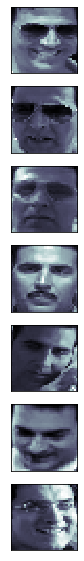

In [66]:
# Show quantitative results such as examples of correct prediction and wrong prediction
print("Examples of wrong predictions:")
ind = np.where(results == False)
wrong = np.asarray([data[i] for i in ind])
wrong = wrong.reshape(wrong.shape[1], wrong.shape[2])
wrong = wrong.reshape((wrong.shape[0],32,32))
fig = plt.figure(figsize=(10, 10))
for i in range(wrong.shape[0]):
    ax = fig.add_subplot(wrong.shape[0], 1, i+1 , xticks=[], yticks=[])
    ax.imshow(wrong[i], cmap=plt.cm.bone)
